In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

############
import os
import sys
from packaging import version
import sklearn
import tensorflow as tf

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
assert version.parse(tf.__version__) >= version.parse("2.8.0")
###########

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
#print("MPS backend available:", tf.backends.mps.is_built())

TensorFlow version: 2.20.0
Keras version: 3.11.3
GPU available: []


In [2]:
input_data = pd.read_pickle('../dados/df_ata_sentimento.pkl') 
#input_data = pd.read_json('../dados/df_ata_sentimento.json', orient='records', lines=True)
#input_data['Data'] = pd.to_datetime(input_data['Data']).dt.date
#input_data.tail()
# A obtenção de dados da coluna Selic 6m dixa lacunas, limpar os dados:
input_data = input_data.dropna(subset=['Sentimento','Texto'])
input_data = input_data[~(input_data['Texto'].str.strip().isna() | (input_data['Texto'].str.strip() == ''))]
input_data['Texto'] = input_data['Texto'].str.lower()

input_data.sample(5)

,Data,Texto,Selic,IPCA,Selic (6m),Sentimento
160,2016-01-20,sumário evolução recente da economia avaliação...,14.25,10.71,14.25,neutral
102,2008-10-29,sumário evolução recente da economia avaliação...,13.75,6.41,11.25,dovish
199,2020-12-09,a atualização da conjuntura econômica e do cen...,2.00,4.52,3.50,hawkish
14,2000-08-23,sumário demanda e oferta agregadas ambiente ex...,16.50,7.86,16.50,neutral
114,2010-04-28,sumário evolução recente da economia avaliação...,8.75,5.26,10.75,hawkish


In [3]:
base_data = input_data[['Texto','Sentimento']]

filename_root = 'gru_sentimento_6m_'
subset_dir = '../../subsets/'
model_dir = '../../'
subset_dir = '../../subsets/'
basepickle = subset_dir + filename_root + '__base.pkl'
base_data.to_pickle(basepickle)
print(base_data.sample(5))
print('Records: ',len(base_data))

                                                 Texto Sentimento
213  a atualização da conjuntura econômica e do cen...    neutral
75   sumário evolução recente da inflação avaliação...     dovish
231  a atualização da conjuntura econômica e do cen...    hawkish
138  sumário evolução recente da economia avaliação...    hawkish
100  sumário evolução recente da economia avaliação...    hawkish
Records:  206


In [4]:
from sklearn.preprocessing import LabelEncoder
#tratamento dos dados para modelo
training_data = base_data.copy()
#Encoding do label alfanumérico
label_encoder = LabelEncoder()
training_data.loc[:, 'sent_encoded'] = label_encoder.fit_transform(training_data['Sentimento'])


# Criando 3 colnuas com hot encoding
one_hot = pd.get_dummies(training_data['Sentimento'], prefix='sent')
training_data = pd.concat([training_data, one_hot], axis=1)

# Renomeando colunas
training_data = training_data.rename(columns={'Texto': 'text'})
training_data = training_data.rename(columns={'Sentimento': 'sent'})

# Display the result
print(training_data.sample(5))

                                                  text     sent  sent_encoded  \
41   sumário atividade econômica ambiente externo p...  hawkish             1   
223  a atualização da conjuntura econômica e do cen...   dovish             0   
202  a atualização da conjuntura econômica e do cen...  hawkish             1   
16   sumário demanda e oferta agregadas ambiente ex...   dovish             0   
32   sumário atividade econômica ambiente externo p...   dovish             0   

     sent_dovish  sent_hawkish  sent_neutral  
41         False          True         False  
223         True         False         False  
202        False          True         False  
16          True         False         False  
32          True         False         False  


In [5]:

# Switch de qual label vai ser estudado.
label_set = 'sent_encoded'
#label_set = 'sent_dovish'
#label_set = 'sent_hawkish'
#label_set = 'sent_neutral'

#Globais de processsamento
batch_size = 32
rnd_seed = 42
set_rnd_seed = 145
num_epochs = 200
num_batches = 32
token_count = 30000
padding_size = 80000
embed_size = 128
train_ratio = 0.8
valid_ratio = 0.1

model_file = model_dir + filename_root + '_GRU_0801_modl_' + label_set + '_' + str(num_epochs) + '_mzt_220_B32.keras'
ckpt_file = model_dir + filename_root + '_GRU_0801_chkp_' + label_set + '_' + str(num_epochs) + '_mzt_220_B32.keras'
print(model_file)
print(ckpt_file)

../../gru_sentimento_6m__GRU_0801_modl_sent_encoded_200_mzt_220_B32.keras
../../gru_sentimento_6m__GRU_0801_chkp_sent_encoded_200_mzt_220_B32.keras


In [6]:
from sklearn.model_selection import train_test_split

tf.random.set_seed(set_rnd_seed)

#Migrando dados parsa dataset TensorFlow
df = pd.DataFrame()
df['text'] = training_data['text'].str.lower()
df['label'] = training_data[label_set]  
print(df.head())

# Convert DataFrame to tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((df['text'].values, df['label'].values))

# Optional: Split into train, validation, and test sets (e.g., 80%/10%/10%)
dataset_size = len(df)
train_size = int(train_ratio * dataset_size)
valid_size = int(valid_ratio * dataset_size)
test_size = dataset_size - train_size - valid_size

# Shuffle the dataset (optional, use a seed for reproducibility)
dataset = dataset.shuffle(buffer_size=dataset_size, seed=rnd_seed)

# Split the dataset
raw_train_set = dataset.take(train_size)
raw_valid_set = dataset.skip(train_size).take(valid_size)
raw_test_set = dataset.skip(train_size + valid_size)

print("Train size:", train_size)
print("Valid size:", valid_size)
print("Test size:", test_size)
# Verify the datasets
for text, label in raw_train_set.take(4):
    print("Text:", text.numpy().decode('utf-8')[:100], "Label:", label.numpy())


                                                text  label
0  sumário preços e nível de atividade agregados ...      0
1  sumário preços e nível de atividade agregados ...      0
2  sumário demanda e oferta agregadas preços agre...      0
3  sumário demanda e oferta agregadas ambiente ex...      0
4  sumário demanda e oferta agregadas ambiente ex...      2
Train size: 164
Valid size: 20
Test size: 22
Text: a atualização da conjuntura econômica e do cenário do copom11 o ambiente externo permanece desafiado Label: 1
Text: sumário atividade econômica ambiente externo preços mercado monetário e operações de mercado aberto  Label: 0
Text: sumário evolução recente da inflação avaliação prospectiva das tendências da inflação implementação  Label: 0
Text: sumário demanda e oferta agregadas ambiente externo preços avaliação prospectiva das tendências da i Label: 2


2025-10-19 12:23:24.437159: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
#Preparar datasets TensorFlow

train_set = raw_train_set.shuffle(100, seed=rnd_seed).batch(batch_size).prefetch(1)
valid_set = raw_valid_set.batch(batch_size).prefetch(1)
test_set = raw_test_set.batch(batch_size).prefetch(1)

for ata, sentiment in raw_train_set.take(4):
    print(ata.numpy().decode("utf-8")[:200], "...")
    print("Sentiment:", sentiment.numpy())

sumário evolução recente da economia avaliação prospectiva das tendências da inflação implementação da política monetária inflação atividade econômica expectativas e sondagens mercado de trabalho créd ...
Sentiment: 0
sumário evolução recente da economia avaliação prospectiva das tendências da inflação implementação da política monetária inflação atividade econômica expectativas e sondagens mercado de trabalho créd ...
Sentiment: 0
sumário atividade econômica ambiente externo preços mercado monetário e operações de mercado aberto avaliação prospectiva das tendências da inflação diretrizes da política monetária glossário data 16  ...
Sentiment: 1
sumário evolução recente da economia avaliação prospectiva das tendências da inflação implementação da política monetária inflação atividade econômica expectativas e sondagens mercado de trabalho créd ...
Sentiment: 1


2025-10-19 12:23:24.444048: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:

text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=token_count)
text_vec_layer.adapt(train_set.map(lambda texts, labels: texts))


In [9]:
#Masking Automatico



tf.random.set_seed(rnd_seed)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(token_count, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    #tf.keras.layers.Dense(1, activation="sigmoid")# binário
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes
])

# Define callback to save the best model based on validation loss
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    ckpt_file,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False
)

# If your labels are integers, convert them to one-hot encoded format
# Assuming train_set and valid_set are tf.data.Dataset objects
def convert_to_one_hot(dataset):
    def process_features_labels(features, labels):
        # Convert integer labels to one-hot encoded labels
        labels = tf.one_hot(labels, depth=3)  # depth=3 for 3 classes
        return features, labels
    return dataset.map(process_features_labels)

# Apply one-hot encoding to datasets
train_set_oh = convert_to_one_hot(train_set)
valid_set_oh = convert_to_one_hot(valid_set)

print("Start: ", datetime.now())
#model.compile(loss="binary_crossentropy", optimizer="nadam",
#              metrics=["accuracy"]) # binário
model.compile(loss="categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(
    train_set_oh,
    validation_data=valid_set_oh,
    epochs=num_epochs,
    callbacks=[checkpoint_cb]
)
print("End: ", datetime.now())

Start:  2025-10-19 12:23:24.561415
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.5183 - loss: 1.0839 - val_accuracy: 0.5000 - val_loss: 1.0495
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.6098 - loss: 1.0317 - val_accuracy: 0.5000 - val_loss: 1.0138
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.6220 - loss: 0.9388 - val_accuracy: 0.6500 - val_loss: 0.7953
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step - accuracy: 0.6280 - loss: 0.8450 - val_accuracy: 0.5500 - val_loss: 1.0033
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.6829 - loss: 0.7570 - val_accuracy: 0.8000 - val_loss: 0.6218
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 54s 9s/step - accuracy: 0.7439 - loss: 0.6876 - val_accuracy: 0.6500 - val_loss: 0.7119
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.6951 - loss: 0.7463 - val_accuracy: 0.6000 - val_loss: 0.7682
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.7500 - loss: 0.6243 - val_a

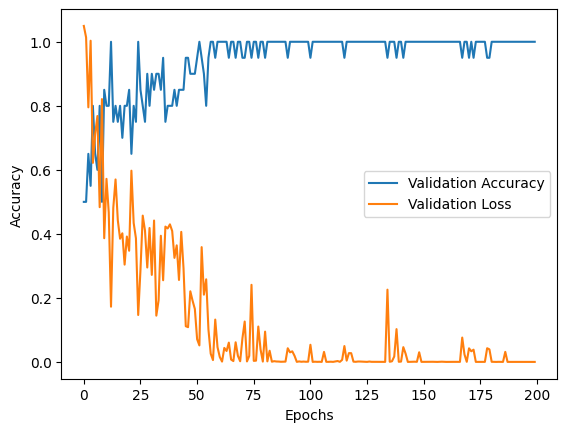

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
#Salvando datasets
test_set_dir = subset_dir + filename_root + f"tr_ {train_ratio:.2f}" + "_test_set"
os.makedirs(test_set_dir, exist_ok=True)
tf.data.Dataset.save(test_set, test_set_dir)
print(test_set_dir)

train_set_dir = subset_dir + filename_root + f"tr_ {train_ratio:.2f}" + "_train_set"
os.makedirs(train_set_dir, exist_ok=True)
tf.data.Dataset.save(train_set, test_set_dir)
print(train_set_dir)

valid_set_dir = subset_dir + filename_root + f"tr_ {train_ratio:.2f}" + "_valid_set"
os.makedirs(valid_set_dir, exist_ok=True)
tf.data.Dataset.save(valid_set, valid_set_dir)
print(valid_set_dir)

../../subsets/gru_sentimento_6m_tr_ 0.80_test_set
../../subsets/gru_sentimento_6m_tr_ 0.80_train_set
../../subsets/gru_sentimento_6m_tr_ 0.80_valid_set


In [12]:
import keras
print(model_file)
keras.saving.save_model(model, model_file)

../../gru_sentimento_6m__GRU_0801_modl_sent_encoded_200_mzt_220_B32.keras


In [14]:
test_set_oh = convert_to_one_hot(test_set)
test_loss, test_accuracy = model.evaluate(test_set_oh)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.7295e-04
Test Accuracy: 1.0000
Test Loss: 0.0002


In [15]:
# Step 1: Extract true labels and predictions
y_true = []
y_pred = []

for x_batch, y_batch in test_set_oh:
    # Get true labels (one-hot encoded) and convert to class indices
    y_true_batch = tf.argmax(y_batch, axis=1).numpy()  # Convert one-hot to indices
    y_true.extend(y_true_batch)
    
    # Get model predictions and convert to class indices
    y_pred_prob = model.predict(x_batch, verbose=0)  # Predict probabilities
    y_pred_batch = tf.argmax(y_pred_prob, axis=1).numpy()  # Convert to indices
    y_pred.extend(y_pred_batch)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2025-10-19 15:58:22.579305: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


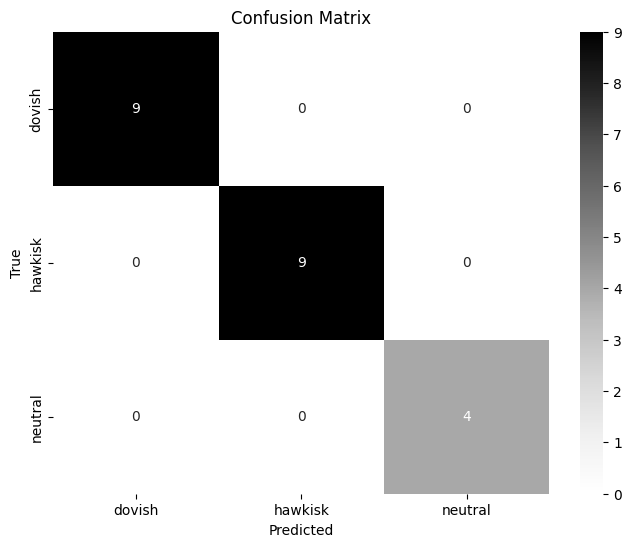

Confusion Matrix:
 [[9 0 0]
 [0 9 0]
 [0 0 4]]


In [16]:
#0 = dovish
#1 = hawkisk
#2 = neutral

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Visualize the confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Grays', 
            xticklabels=['dovish', 'hawkisk', 'neutral'], 
            yticklabels=['dovish', 'hawkisk', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:\n", cm)